# Sentiment Analysis of tweets about Ethereum
> "An analysis of how twitters users feel about ethereum"

- toc: true
- branch: master
- badges: true
- comments: true
- author: Enobong Udoh
- categories: [Ethereum, sentiment analysis, tweets]
- image: images/project_thumbnails/sentiments.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2



### Project Motivation:
I recently started investing in stocks and a few crypto currencies and as a new investor, one very difficult thing has been gauging the sentiments of other investors to support my decisions. 

Prior to now, I'd spend long hours looking through series of tweets to gain a sense of how others feel. This has not only been a time consuming task but also, often counter productive as I end up getting really overwhelmed and unable to make any informed decision.
<br>

### Project Goal:
This project aims to analyze over 400 tweets from twitter about etherium from 01-08-2015 to 05-10-2020. It gives a sense of their sentiments and some commonly used positive words, to support investment decision making in a fraction of the time it would take to manually perform this task.

In [4]:
# installing packages used in program
!pip install demoji

In [5]:
# importing libraries
import sys
import tweepy 
from textblob import TextBlob   # gives sentiments and polarity of regular text/sentence from -1 to 1 where 0 is neutral
import pandas as pd
import numpy as np
import re  # re= regular expressions
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime 
import seaborn as sns
plt.style.use('fivethirtyeight')
import demoji
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
# import warnings
# warnings.filterwarnings('ignore')

## DATA PREPARATION

### **Accessing Twitter to scrape comments**

In [ ]:
# upload login credential file
from google.colab import files
files.upload()

In [ ]:
# store the uploaded login file in a variable
pd.set_option('display.width', None)
log = pd.read_csv('twitter_app_cred.csv') 
log

In [ ]:
# get the twitter API credentials
consumerKey = log['consumer_key'][0]
consumerSecret = log['consumer_secret'][0]
accessToken = log['access_token'][0]
accessTokenSecret = log['access_token_secret'][0]

In [ ]:
# create authentication object from tweepy - pass consumer key and secret
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)

In [ ]:
# set access token and access token secret for the authentication object
authenticate.set_access_token(accessToken, accessTokenSecret)

In [ ]:
# create the API object for this program

# FYI: wait_on_rate_limit – Whether or not to automatically wait for rate limits to replenish. 
# Twitter levies a rate limit on the number of requests made to the Twitter API. To be precise, 900 requests/15 minutes are allowed; Twitter feeds anything above that an error

api = tweepy.API(authenticate, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)



In [ ]:
'''
This function accepts search elements that are passed to the api to generate data.
'''

def get_search_info():
  # get the search terms as input
  search_term = input("Enter keyword/hashtag for analysis:")

  # get the no_of_search_terms
  no_of_search_terms = int(input("Enter the number of tweets to be analyzed:"))

  # get the start date
  start_date = datetime.strptime(input("Enter the start date for data extraction (dd-mm-yyyy):"), '%d-%m-%Y')
 

  # get the end date
  until_date = datetime.strptime(input("Enter the end date for data extraction (dd-mm-yyyy):"), '%d-%m-%Y')
      
  return search_term, no_of_search_terms, start_date, until_date
 

  

In [ ]:
# Pass the search_term, no_of_search_terms, start_date, until_date to the program

print("Welcome to the twitter sentiment analysis program. **Please note that data does not include retweets")
search_term, no_of_search_terms, start_date, until_date = get_search_info()

print('\n Entries are in the correct format and processing can commence')



In [ ]:
# create a cursor object
tweets = tweepy.Cursor(api.search, q=f'{search_term}-filter:retweets', lang='en', since= start_date, until = until_date, tweet_mode='extended').items(no_of_search_terms )


In [ ]:
# get a list of all tweets
all_tweets = [[ each_tweet.user.id_str, each_tweet.user.location, each_tweet.full_text] for each_tweet in tweets]

# creating a data frame of tweets
tweet_df = pd.DataFrame(all_tweets, columns=['user_id', 'location', 'tweets'])

# storing result in as a pickle file
tweet_df.to_pickle('tweets.pickle')
# tweet_df.to_pickle('data/ethereum_data/tweets.pickle')


### **Cleaning Data**

In [6]:
df_raw = pd.read_pickle('tweets.pickle')
df_raw.head(3)

,user_id,location,tweets
0,1440248590547361798,Ethereum Blockchain,Publicly announcing Wall Street Champs. A coll...
1,1367942471888613376,Switzerland,TIME-STAMPED SHOW NOTES: [00:25] Today’s topi...
2,1422127209721090050,,@YakuzaNFT Launching Friday Oct 8th\n \nOne o...


In [7]:
# create a modifiable copy of the data while maintaining the raw version.
df = df_raw.copy()

In [8]:
'''
This function helps with cleaning the tweets
'''
def cleaner(twt):
  twt = re.sub('#', '', twt)  # removes the # from bitcoin
  twt = re.sub('#[A-Za-z0-9]+', ' ', twt)   # removes every # followed by a letter or number and more (denoted by +) and leave empty
  twt = re.sub('\\n', ' ', twt)  # removing \n string. extra \ was added to make python read \n as normal text
  twt = re.sub('http?s\/\/S+','', twt)   # removes hyperlink. '?' finds 0 or 1 s as some might be http, others https. \ are used here too to make the // normal text. S+ is used to denote any other character
  twt = re.sub("''",'', twt)   
  return twt

# iterate over tweets column to clean and remove emojis
tweet_hold = []
for i in df.tweets:
  tweet_hold.append(demoji.replace(cleaner(i), ''))

# create a column of clean tweets
df['clean_tweets'] = tweet_hold


In [9]:
df.head(3)

,user_id,location,tweets,clean_tweets
0,1440248590547361798,Ethereum Blockchain,Publicly announcing Wall Street Champs. A coll...,Publicly announcing Wall Street Champs. A coll...
1,1367942471888613376,Switzerland,TIME-STAMPED SHOW NOTES: [00:25] Today’s topi...,TIME-STAMPED SHOW NOTES: [00:25] Today’s topi...
2,1422127209721090050,,@YakuzaNFT Launching Friday Oct 8th\n \nOne o...,@YakuzaNFT Launching Friday Oct 8th One of ...


**Checking for missing values**

In [10]:
# review data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       453 non-null    object
 1   location      453 non-null    object
 2   tweets        453 non-null    object
 3   clean_tweets  453 non-null    object
dtypes: object(4)
memory usage: 14.3+ KB


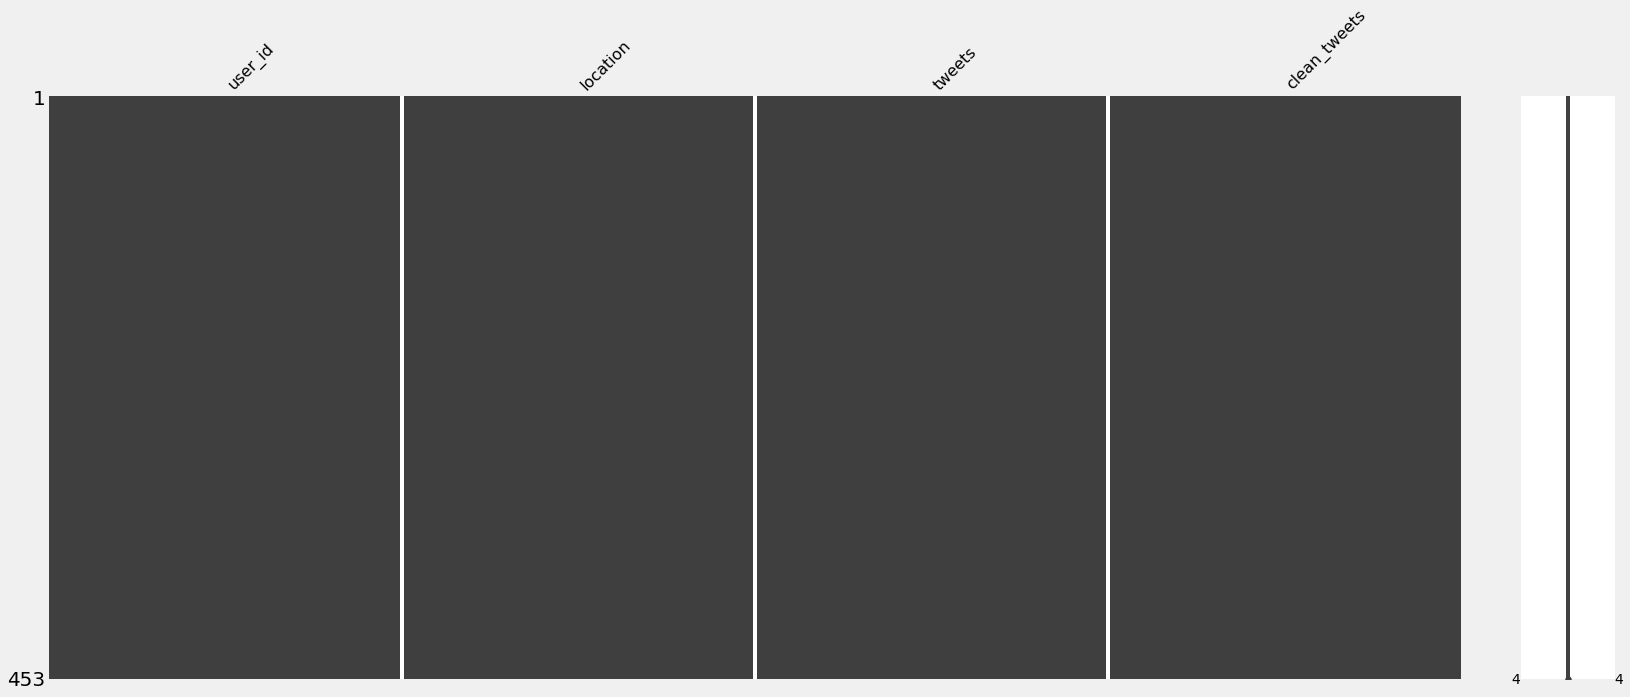

In [11]:
# plot the columns to check for missing data
import missingno
missingno.matrix(df)
plt.show()

> **Observation**: While the check for null values shows there's none in the data, the location column has some gaps. Next, review the unique value that make up the location column

In [12]:
# get unique locations in data
df.location.unique()

array(['Ethereum Blockchain', 'Switzerland', '', 'Blockchain', 'Spain',
       'Based Basement', 'New Orleans, LA',
       'Tennis Paradise - Indian Wells', 'Brooklyn, NY', 'Moon',
       'BAT Tips accepted here', 'Germany, Berlin',
       'AWS eu-west-1a Ireland Region', 'Frankfurt on the Main, Germany',
       'The Moon', 'Coingecko', 'Binance Smart Chain', 'London, England',
       'Thailang', 'New York.', 'Atlanta, GA', 'Hong Kong', '    ',
       'Nashville, TN', 'India', 'Far side of the Moon!', 'Phoenix, AZ',
       'Germany', 'Dharma Initiative', '🇲🇾',
       'https://www.cryptosbulls.com', 'Metaverse', 'Thailand',
       'NOT FINANCIAL ADVICE', 'New York, USA', 'ÜT: 51.427077,6.105739',
       'ETH', 'Kenigsberg', 'USA', 'Cryptoverse', '🇸🇦', 'Global',
       'jabalpur', 'Not affiliated with Coinbase', 'Paris, France',
       'Tamil Nadu, India', 'London', 'Trade here 👉', 'Weimar, Germany',
       'HongKong', 'Estonia', 'Montreal, Canada', 'ToTheMoon',
       'Venezuela', 'CRYP

> **Observation**: It can be observed that '' is recorded as a location and might account for the seemingly empty fields in the data. Also, some of the locations captured are not places in the world, hence, drop column.

In [13]:
# remove unused column
df = df.drop(columns='location')

**Checking for duplicates**

In [14]:
# check if there are any duplicates
df.duplicated().any()

True

In [15]:
# find duplicated record
df[df.duplicated()==True]

,user_id,tweets,clean_tweets
369,1420829930762514435,We're glad to announce next Plant Token AMA wi...,We're glad to announce next Plant Token AMA wi...


In [16]:
# drop duplicated data but keep the first record of the said data and reset the index
df.drop_duplicates(keep='first',inplace=True)
df.reset_index(drop=True, inplace=True)

In [17]:
# verifying info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       452 non-null    object
 1   tweets        452 non-null    object
 2   clean_tweets  452 non-null    object
dtypes: object(3)
memory usage: 10.7+ KB


In [18]:
# rechecking for duplicates
df.duplicated().any()

False

> **Conclusion:** The data has been cleaned for analysis

## DATA ANALYSIS



### **What is the spread of opinions about Ethereum on twitter?**

In [19]:
# get subjectivity
def get_subjectivity(twitts):
  return TextBlob(twitts).sentiment.subjectivity

# get polarity
def get_polarity(twitts):
  return TextBlob(twitts).sentiment.polarity

In [20]:
# create two columns called cubjectivity and polarity
df['subjectivity'] = df['clean_tweets'].apply(get_subjectivity)
df['polarity'] = df['clean_tweets'].apply(get_polarity)
df.head(5)

,user_id,tweets,clean_tweets,subjectivity,polarity
0,1440248590547361798,Publicly announcing Wall Street Champs. A coll...,Publicly announcing Wall Street Champs. A coll...,0.406667,0.155000
1,1367942471888613376,TIME-STAMPED SHOW NOTES: [00:25] Today’s topi...,TIME-STAMPED SHOW NOTES: [00:25] Today’s topi...,0.821429,-0.267857
2,1422127209721090050,@YakuzaNFT Launching Friday Oct 8th\n \nOne o...,@YakuzaNFT Launching Friday Oct 8th One of ...,0.750000,0.437500
3,726437948527398912,"Ethereum - ETH\nPrice: $3,392.68\nChange in 1h...","Ethereum - ETH Price: $3,392.68 Change in 1h: ...",0.000000,0.000000
4,47313788,"Mother.\n\n1 of 1 • On sale from 7th Oct, 4:00...","Mother. 1 of 1 • On sale from 7th Oct, 4:00 a...",0.000000,0.000000


In [21]:
# create a function to get the sentiment text
def get_sentiment(rank):
  if rank < 0:
    return 'Negative'
  elif rank == 0:
    return 'Neutral'
  else:
    return 'Positive'

In [22]:
# create a column to store the sentiment text
df['sentiment'] = df['polarity']. apply(get_sentiment)
# show the data
df.head()

,user_id,tweets,clean_tweets,subjectivity,polarity,sentiment
0,1440248590547361798,Publicly announcing Wall Street Champs. A coll...,Publicly announcing Wall Street Champs. A coll...,0.406667,0.155000,Positive
1,1367942471888613376,TIME-STAMPED SHOW NOTES: [00:25] Today’s topi...,TIME-STAMPED SHOW NOTES: [00:25] Today’s topi...,0.821429,-0.267857,Negative
2,1422127209721090050,@YakuzaNFT Launching Friday Oct 8th\n \nOne o...,@YakuzaNFT Launching Friday Oct 8th One of ...,0.750000,0.437500,Positive
3,726437948527398912,"Ethereum - ETH\nPrice: $3,392.68\nChange in 1h...","Ethereum - ETH Price: $3,392.68 Change in 1h: ...",0.000000,0.000000,Neutral
4,47313788,"Mother.\n\n1 of 1 • On sale from 7th Oct, 4:00...","Mother. 1 of 1 • On sale from 7th Oct, 4:00 a...",0.000000,0.000000,Neutral


In [39]:
# getting a sense of the value counts and key arrangements
val_count=df['sentiment'].value_counts()
val_keys=df['sentiment'].value_counts().keys()
print(val_keys)
val_count

Index(['Neutral', 'Positive', 'Negative'], dtype='object')


Neutral     266
Positive    119
Negative     67
Name: sentiment, dtype: int64

In [48]:
# making a df of sentiment counts
cummulative_sentiment_df = pd.DataFrame(val_count)
cummulative_sentiment_df.reset_index(inplace=True)

In [53]:
# renaming the columns 
cummulative_sentiment_df.columns=['sentiment', 'score']
cummulative_sentiment_df

,sentiment,score
0,Neutral,266
1,Positive,119
2,Negative,67


In [87]:
# create a bar chart to show the count of positive, neutral and negative sentiments
fig = px.bar(cummulative_sentiment_df, x='sentiment', y='score', 
            color='sentiment', color_discrete_map={
                "Neutral": "orange",
                "Positive": "green",
                "Negative": "red"},
            opacity = 0.9,
            labels ={'x':'Sentiment','y':'Count'}, title="Sentiment Analysis Bar Plot", 
            template = "plotly_dark")
fig.update_layout(
      title={
        'text': "Sentiment Analysis of tweets on Ethereum",
        'y':0.9,
        'x':0.46,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
        family="Courier New, monospace",
        size=24,
        color="White"
        )
        }
)
fig.show()

### **What are some of the top positive words used in tweets about ethereum?**

In [ ]:
# generating a world cloud from the positive tweets
positive_df = df[df['sentiment']=='Positive']

stopwords = set(STOPWORDS)
stopwords.update(["br", "href", "https", "BTC","ETH", "USDT","XRP", "Last Year", "ether",
                  "eth","unkown wallet","Co", "NFT", "Crypto Exchange","Bitcoin","Ethereum",
                  "GwaCvQyQbc","Trading","Exchange","Crptocurrency", "Crypto","altcoin","will",
                  "Oct","Credit Card","Card","Credit"])  
each_word = "".join( words for words in positive_df.tweets)
word_cloud = WordCloud(stopwords=stopwords, background_color='black').generate(each_word)
plt.figure(figsize=(9,5))
plt.title("A world cloud from the positive tweets")
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## DATA MODELLING AND VALIDATION

In [ ]:
# Create a data frame with only positive and negative tweets
non_neutral_df = df[df['polarity'] != 0]

# checking that only the needed sentiments are retained
non_neutral_df.reset_index(drop=True, inplace=True) 

# creating a column that scores positive sentiment as 1 and negative as 0
non_neutral_df['sentiment_score'] = np.where(non_neutral_df['sentiment']=='Positive',1,0)


In [ ]:
non_neutral_df.head(2)

In [ ]:
# model stuff - using only non-neutral df
# create a bag_words variable for splitting tweets into words
bag_words = text.CountVectorizer(stop_words='english')

# tranform tweets into individual words
bag_words.fit(non_neutral_df['clean_tweets'])

In [ ]:
# getting every word in the bag
all_words = bag_words.get_feature_names()

len(all_words)

In [ ]:
# create a kfold split to generate 3 sets of train and test data that can validate model
kf = KFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
# defining the predictor and prediction variable
X= bag_words.transform(non_neutral_df['clean_tweets'])  # transform behaves similarly to predict. Uses the bag of words to review each full_text/sentence tweet  
y= non_neutral_df['sentiment_score']

In [ ]:
print(len(y))
X

In [ ]:
# spliting X and y into two sets
set1, set2, set3 = kf.split(X,y)
set1

In [ ]:
# Creating the test and train X and y of each set
# set 1
set1_train_X = X[set1[0]]
set1_train_y = y[set1[0]]

set1_test_X = X[set1[1]]
set1_test_y = y[set1[1]]


# set 2 --
set2_train_X = X[set2[0]]
set2_train_y = y[set2[0]]

set2_test_X = X[set2[1]]
set2_test_y = y[set2[1]]


# set 3 --
set3_train_X = X[set3[0]]
set3_train_y = y[set3[0]]

set3_test_X = X[set3[1]]
set3_test_y = y[set3[1]]

**WORKING WITH SET 1 TO VALIDATE THE MODEL**

In [ ]:
# fitting the naive bayes model
sentiment_nb = MultinomialNB()
set1_result = sentiment_nb.fit(set1_train_X, set1_train_y)
# model score
set1_result.score(set1_train_X, set1_train_y)

In [ ]:
# creating a dataset with set 1 test indices
set1_non_neutral_df = non_neutral_df.loc[set1[1]]
set1_non_neutral_df.head(2)

In [ ]:
# model prediction
set1_non_neutral_df['pred_sentiment_nb'] = set1_result.predict(set1_test_X)
set1_non_neutral_df.tail(5)

In [ ]:
# calculating model metrices, rounded to 3 decimal places
print(f"The mean_squared error for set 1 is: {round(mean_squared_error(set1_non_neutral_df['sentiment_score'], set1_non_neutral_df['pred_sentiment_nb']), 3)}")
print(f"The mean_absolute error for set 1 is: {round(mean_absolute_error(set1_non_neutral_df['sentiment_score'], set1_non_neutral_df['pred_sentiment_nb']), 3)}")
print(f"The r2 score for set 1 is: {round(r2_score(set1_non_neutral_df['sentiment_score'], set1_non_neutral_df['pred_sentiment_nb']), 3)}")

> While the model score at training is 1, the r2 score on the test data is 0.516 which indicates that the model accuracy is not high for predicting external data.
 

**WORKING WITH SET 2 TO VALIDATE THE MODEL**

In [ ]:
# fitting the naive bayes model
sentiment_nb = MultinomialNB()
set2_result = sentiment_nb.fit(set2_train_X, set2_train_y)
# model score
set2_result.score(set2_train_X, set2_train_y)

In [ ]:
# creating a dataset with set 2 test indices
set2_non_neutral_df = non_neutral_df.loc[set2[1]]

# adding a prediction column for set2 test data to the df above
set2_non_neutral_df['pred_sentiment_nb'] = set2_result.predict(set2_test_X)

In [ ]:
# calculating model metrices, rounded to 3 decimal places
print(f"The mean_squared error for set 2 is: {round(mean_squared_error(set2_non_neutral_df['sentiment_score'], set2_non_neutral_df['pred_sentiment_nb']), 3)}")
print(f"The mean_absolute error for set 2 is: {round(mean_absolute_error(set2_non_neutral_df['sentiment_score'], set2_non_neutral_df['pred_sentiment_nb']), 3)}")
print(f"The r2 score for set 2 is: {round(r2_score(set2_non_neutral_df['sentiment_score'], set2_non_neutral_df['pred_sentiment_nb']), 3)}")

> set 2 has a better accuracy score than set 1. Let's see if set 3 improves the score.

**WORKING WITH SET 3 TO VALIDATE THE MODEL**

In [ ]:
# fitting the naive bayes model
sentiment_nb = MultinomialNB()
set3_result = sentiment_nb.fit(set3_train_X, set3_train_y)
# model score
set3_result.score(set3_train_X, set3_train_y)

In [ ]:
# creating a dataset with set 2 test indices
set3_non_neutral_df = non_neutral_df.loc[set3[1]]

# adding a prediction column for set2 test data to the df above
set3_non_neutral_df['pred_sentiment_nb'] = set3_result.predict(set3_test_X)

In [ ]:
# calculating model metrices, rounded to 3 decimal places
print(f"The mean_squared error for set 3 is: {round(mean_squared_error(set3_non_neutral_df['sentiment_score'], set3_non_neutral_df['pred_sentiment_nb']), 3)}")
print(f"The mean_absolute error for set 3 is: {round(mean_absolute_error(set3_non_neutral_df['sentiment_score'], set3_non_neutral_df['pred_sentiment_nb']), 3)}")
print(f"The r2 score for set 3 is: {round(r2_score(set3_non_neutral_df['sentiment_score'], set3_non_neutral_df['pred_sentiment_nb']), 3)}")

**Observation:**
- Of the 3 sets of data for training the naive bayes model, set 2 had the best accuracy. Hence the features (X) and target (y) from set 2 would be use to train and test another model.

In [ ]:
# prediction probability
# sentiment_nb.predict_proba(set1_test_X)

**TRAINING AND TESTING DECISION TREE CLASSIFER MODEL**

In [ ]:
# using DECISION TREE CLASSIFIER
sentiment_tree = DecisionTreeClassifier(max_depth=3, random_state=0)
sentiment_tree.fit(set2_train_X,set2_train_y)
print(f"The training model score is {sentiment_tree.score(set2_train_X,set2_train_y)}")

# adding column decision tree prediction results to set2_non_neutral_df
set2_non_neutral_df['pred_sentiment_dt'] = sentiment_tree.predict(set2_test_X)

In [ ]:
print(f"The mean_squared error for set 2 (decison tree) is: {round(mean_squared_error(set2_non_neutral_df['sentiment_score'], set2_non_neutral_df['pred_sentiment_dt']), 3)}")
print(f"The mean_absolute error for set 2 (decison tree) is: {round(mean_absolute_error(set2_non_neutral_df['sentiment_score'], set2_non_neutral_df['pred_sentiment_dt']), 3)}")
print(f"The r2 score for set 2 (decison tree) is: {round(r2_score(set2_non_neutral_df['sentiment_score'], set2_non_neutral_df['pred_sentiment_dt']), 3)}")

In [ ]:
# visulaizing the tree
tree.plot_tree(sentiment_tree)
plt.show()

**TRAINING AND TESTING RANDOM FOREST CLASSIFER MODEL**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# using RANDOM FOREST CLASSIFIER
random_tree = RandomForestClassifier(max_depth=3, random_state=0)
random_tree.fit(set2_train_X,set2_train_y)
print(f"The training model score is {random_tree.score(set2_train_X,set2_train_y)}")

# adding column decision tree prediction results to set2_non_neutral_df
set2_non_neutral_df['pred_sentiment_rd'] = random_tree.predict(set2_test_X)

In [ ]:
print(f"The mean_squared error for set 2 (decison tree) is: {round(mean_squared_error(set2_non_neutral_df['sentiment_score'], set2_non_neutral_df['pred_sentiment_rd']), 3)}")
print(f"The mean_absolute error for set 2 (decison tree) is: {round(mean_absolute_error(set2_non_neutral_df['sentiment_score'], set2_non_neutral_df['pred_sentiment_rd']), 3)}")
print(f"The r2 score for set 2 (decison tree) is: {round(r2_score(set2_non_neutral_df['sentiment_score'], set2_non_neutral_df['pred_sentiment_rd']), 3)}")

**Conclusion:**
- While the model scores have consistently been above 0.95 for the 3 models explored, it can be observed that the score has not been as high during testing. 
- There is a need to increase the train and test data to prevent overfitting and effectively determine the viability of the models (a good spot between variance and bias).